In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import tqdm

In [5]:
df_ = pd.read_sas("stockmonth_1962aug_2016dec.sas7bdat")

In [6]:
df_.shape

(2756056, 97)

In [7]:
df_['permno'] = df_.permno.astype(int)
df_['DATE'] = pd.to_datetime(df_.DATE)

In [8]:
df = df_.copy()

In [9]:
dates = sorted(df.DATE.unique())
permnos = sorted(df.permno.unique())
columns = sorted(col for col in df.columns if col not in ['RET', 'DATE', 'permno'])
len(dates), len(permnos)

(653, 22873)

In [10]:
characteristics = np.full((len(dates), len(permnos), len(df.columns) - 3), np.nan, dtype=np.float32)
returns = np.empty_like(characteristics[:, :, 0], dtype=np.float32)

In [11]:
df.set_index(['permno', 'DATE'], inplace=True, drop=True)
df.sort_index(inplace=True)

In [12]:
for idx, row in tqdm.tqdm(df[columns].iterrows(), total=len(df)):
    permno, date = idx
    characteristics[dates.index(date), permnos.index(permno), :] = row.values
    #returns[dates.index(date), permnos.index(permno)] = row['RET']

100%|██████████| 2756056/2756056 [15:14<00:00, 3015.01it/s]


In [13]:
for idx, row in tqdm.tqdm(df[['RET',]].iterrows(), total=len(df)):
    permno, date = idx
    #characteristics[dates.index(date), permnos.index(permno), :] = row.values
    returns[dates.index(date), permnos.index(permno)] = row['RET']

100%|██████████| 2756056/2756056 [15:20<00:00, 2993.96it/s]


In [14]:
ranks = np.empty_like(characteristics)

In [15]:

b = False

for t, date in tqdm.tqdm(enumerate(dates)):
    for c, col in enumerate(columns):
        unique, inverse, counts = np.unique(characteristics[t, :, c], return_inverse=True, return_counts=True)
        
        if len(unique) <= 2:
            ranks[t, :, c] = 0.0
            continue
        
        rank = inverse / (len(unique) - int(np.isnan(unique[-1])) - 1) - 0.5

        if np.isnan(unique[-1]):
            ranks[t, :, c] = np.where(np.isnan(characteristics[t, :, c]), 0.0, rank)
        else:
            ranks[t, :, c] = rank
        b = True

653it [01:05,  9.96it/s]


In [16]:
seq_len = 12

valids = np.isfinite(characteristics).sum(axis=2) > 67

seq_valids = []
for t, date in enumerate(dates[:-seq_len]):
    seq_valids.append(valids[t:t+seq_len].all(axis=0))

seq_valids = np.array(seq_valids)

(array([1.2180013e+07, 0.0000000e+00, 1.6580000e+03, 3.0769000e+04,
        4.4924000e+04, 1.1281600e+05, 1.1220900e+05, 3.7521900e+05,
        5.1616600e+05, 1.5622950e+06]),
 array([ 0. ,  9.4, 18.8, 28.2, 37.6, 47. , 56.4, 65.8, 75.2, 84.6, 94. ]),
 <BarContainer object of 10 artists>)

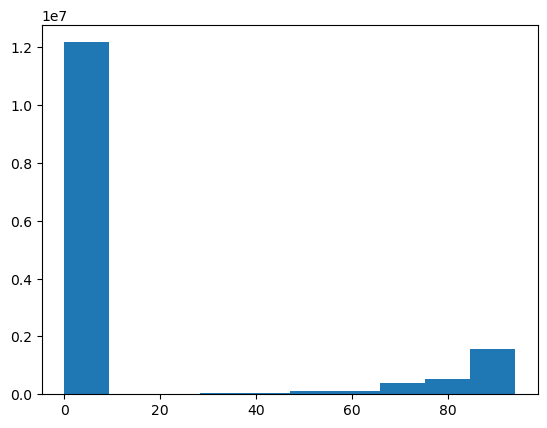

In [17]:
plt.hist(np.isfinite(characteristics).sum(axis=2).flatten())

In [18]:
returns.shape

(653, 22873)

In [20]:
np.savez('data_mynp.npz', ranks=ranks, characteristics=characteristics, dates=dates, permnos=permnos, columns=columns, seq_valids=seq_valids, valids=valids, returns=returns)

In [15]:
ranks.shape

(653, 22873, 94)

In [19]:
valids.shape

(653, 22873)